In [31]:
# Job Postings Exploratory Data Analysis
# This notebook explores the job postings dataset to understand its structure and prepare for duplicate detection.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/skandvijay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# Set plot styling
plt.style.use('ggplot')
sns.set(font_scale=1.2)

# Load the dataset
def load_data(path='data/jobs.csv.zip'):
    """Load job postings dataset."""
    if path.endswith('.zip'):
        df = pd.read_csv(path, compression='zip')
    else:
        df = pd.read_csv(path)
    return df

# Load the data
jobs_df = load_data()

In [7]:
# 1. Basic Dataset Information
print(f"Dataset shape: {jobs_df.shape}")
print("\nColumn names:")
print(jobs_df.columns.tolist())

Dataset shape: (100000, 17)

Column names:
['jobTitle', 'companyName', 'lid', 'jobDescRaw', 'finalZipcode', 'finalState', 'finalCity', 'companyBranchName', 'jobDescUrl', 'nlpBenefits', 'nlpSkills', 'nlpSoftSkills', 'nlpDegreeLevel', 'nlpEmployment', 'nlpSeniority', 'correctDate', 'scrapedLocation']


In [9]:
# 2. Data Types and Missing Values
print("\nData types:")
print(jobs_df.dtypes)


Data types:
jobTitle             object
companyName          object
lid                  object
jobDescRaw           object
finalZipcode         object
finalState           object
finalCity            object
companyBranchName    object
jobDescUrl           object
nlpBenefits          object
nlpSkills            object
nlpSoftSkills        object
nlpDegreeLevel       object
nlpEmployment        object
nlpSeniority         object
correctDate          object
scrapedLocation      object
dtype: object


In [11]:
print("\nMissing values by column:")
print(jobs_df.isnull().sum())


Missing values by column:
jobTitle                0
companyName           325
lid                     0
jobDescRaw              0
finalZipcode         2051
finalState           1420
finalCity            1795
companyBranchName     325
jobDescUrl              0
nlpBenefits             0
nlpSkills               0
nlpSoftSkills           0
nlpDegreeLevel          0
nlpEmployment           0
nlpSeniority            0
correctDate            14
scrapedLocation         0
dtype: int64


In [13]:
# 3. Basic Statistics
print("\nBasic statistics for numeric columns:")
print(jobs_df.describe())


Basic statistics for numeric columns:
               jobTitle companyName                               lid  \
count            100000       99675                            100000   
unique            51692       25503                            100000   
top     Delivery Driver    DoorDash  07213bcc5db0efec311b1884459defed   
freq                736        4438                                 1   

                                               jobDescRaw finalZipcode  \
count                                              100000        97949   
unique                                              90535        17617   
top     <div class="show-more-less-html__markup show-m...       remote   
freq                                                  134          635   

       finalState finalCity                        companyBranchName  \
count       98580     98205                                    99675   
unique        247      7071                                    72133   
top     

In [17]:
jobs_df['description_length'] = jobs_df['jobDescRaw'].fillna('').apply(len)

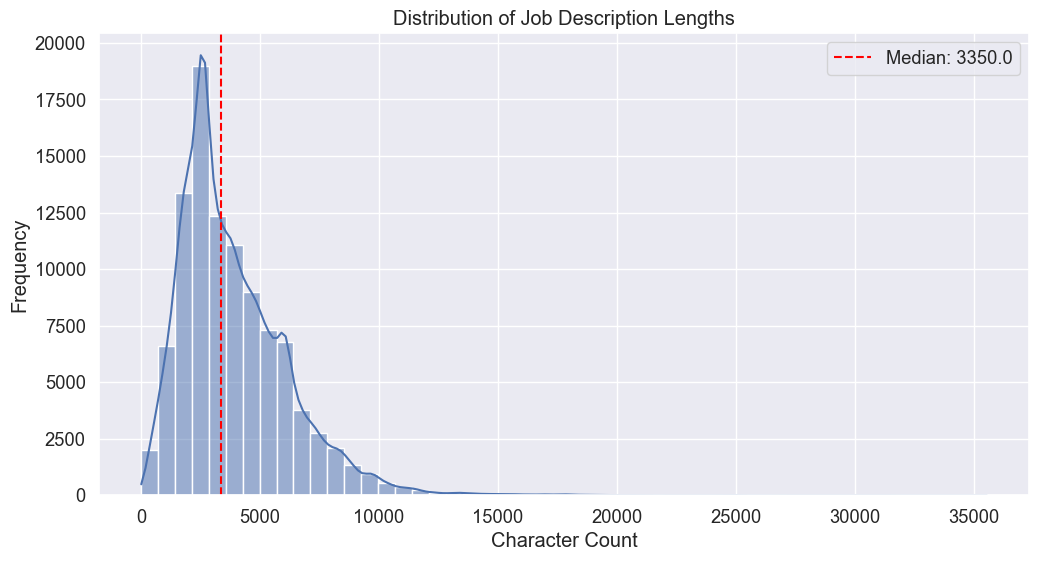

In [19]:
plt.figure(figsize=(12, 6))
sns.histplot(jobs_df['description_length'], bins=50, kde=True)
plt.title('Distribution of Job Description Lengths')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.axvline(jobs_df['description_length'].median(), color='red', linestyle='--', label=f'Median: {jobs_df["description_length"].median()}')
plt.legend()
plt.show()

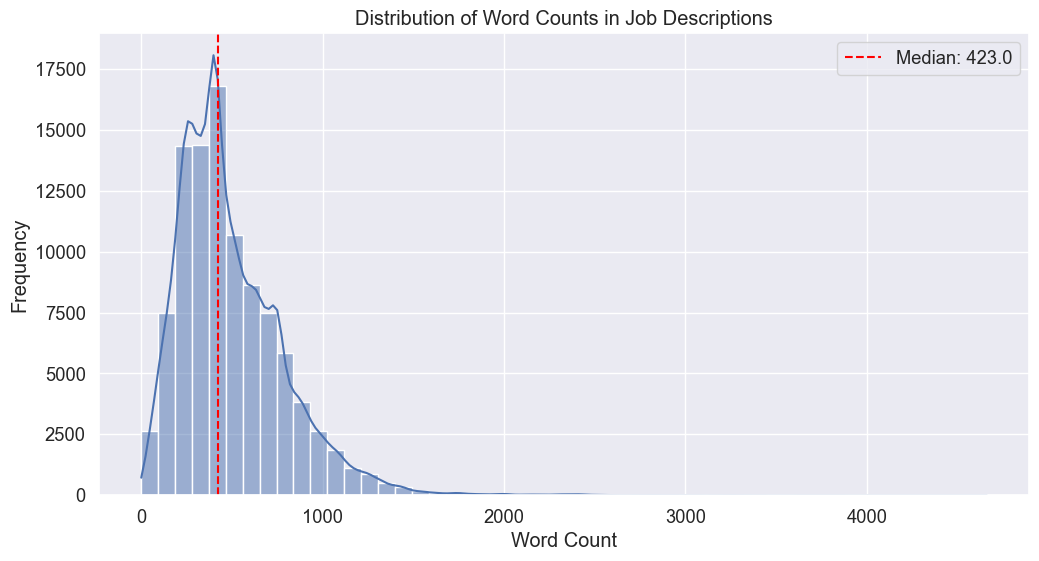

In [23]:
# 5. Word Count Analysis
jobs_df['word_count'] = jobs_df['jobDescRaw'].fillna('').apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
sns.histplot(jobs_df['word_count'], bins=50, kde=True)
plt.title('Distribution of Word Counts in Job Descriptions')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.axvline(jobs_df['word_count'].median(), color='red', linestyle='--', label=f'Median: {jobs_df["word_count"].median()}')
plt.legend()
plt.show()

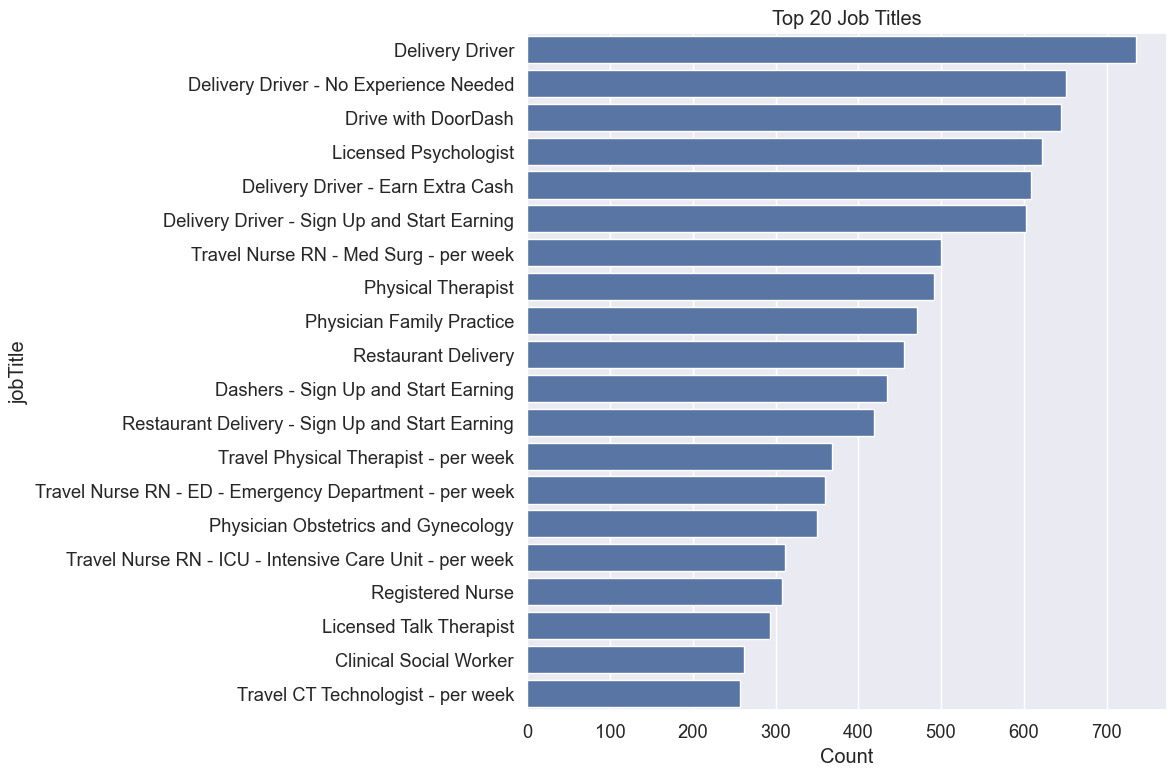

In [27]:
# 6. Top Job Titles
top_job_titles = jobs_df['jobTitle'].value_counts().head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_job_titles.values, y=top_job_titles.index)
plt.title('Top 20 Job Titles')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

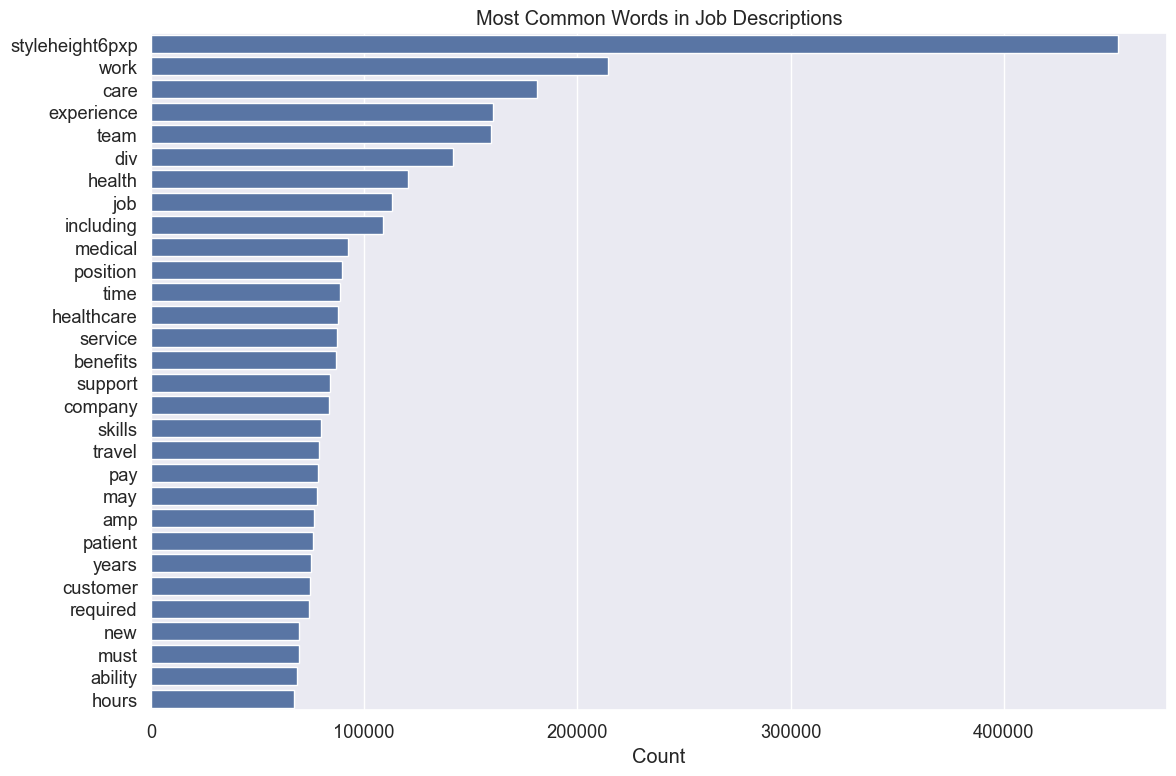

In [35]:
# 7. Common Words in Job Descriptions
def extract_common_words(texts, n=30):
    """Extract the most common words from a list of texts."""
    # Join all texts
    all_text = ' '.join(texts.fillna(''))
    
    # Clean text
    all_text = all_text.lower()
    all_text = re.sub(r'[^\w\s]', '', all_text)
    
    # Tokenize
    words = all_text.split()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words and len(word) > 2]
    
    # Count words
    word_counts = Counter(words)
    
    return word_counts.most_common(n)

common_words = extract_common_words(jobs_df['jobDescRaw'])

plt.figure(figsize=(12, 8))
sns.barplot(x=[count for _, count in common_words], y=[word for word, _ in common_words])
plt.title('Most Common Words in Job Descriptions')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

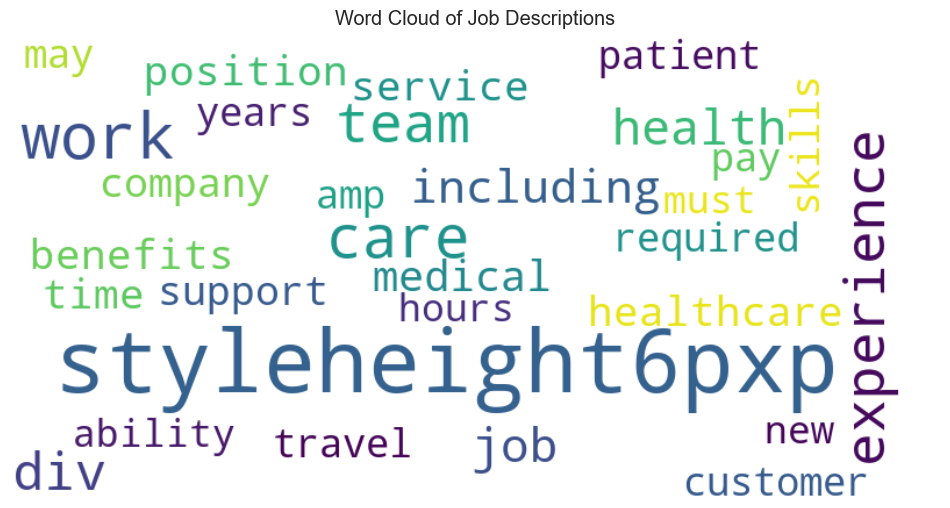

In [37]:
# 8. Word Cloud Visualization
word_counts = dict(common_words)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Job Descriptions')
plt.axis('off')
plt.show()

In [39]:
# 9. Check for Potential Duplicates Based on Exact Matches
exact_duplicates = jobs_df.duplicated(subset=['jobDescRaw'], keep=False)
print(f"\nNumber of potential exact duplicate job descriptions: {exact_duplicates.sum()}")


Number of potential exact duplicate job descriptions: 13170


In [43]:
# Display a few examples of exact duplicates if they exist
if exact_duplicates.sum() > 0:
    print("\nExample of exact duplicates:")
    exact_dup_df = jobs_df[exact_duplicates].sort_values('jobDescRaw').head(2)
    for _, row in exact_dup_df.iterrows():
        print(f"Job ID: {row['lid']}, Title: {row['jobTitle']}")
        print(f"Description (first 100 chars): {row['jobDescRaw'][:100]}...")
        print("-" * 50)


Example of exact duplicates:
Job ID: 9f8f52878862f5ed56249642516bbfda, Title: Label Analyst
Description (first 100 chars): , India<p><br /><b>Job Family Group:</b></p>Downstream Supply Chain<p><br /><b>Worker Type:</b></p>R...
--------------------------------------------------
Job ID: d736ae1c155a59beb64e716e81c446a2, Title: Label Analyst
Description (first 100 chars): , India<p><br /><b>Job Family Group:</b></p>Downstream Supply Chain<p><br /><b>Worker Type:</b></p>R...
--------------------------------------------------


In [45]:
# 10. Looking for Near-Duplicates (Simple Similarity)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Take a small sample for demonstration
sample_size = min(1000, len(jobs_df))
sample_df = jobs_df.sample(sample_size, random_state=42)

# Create TF-IDF vectors
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(sample_df['jobDescRaw'].fillna(''))

# Compute cosine similarity
similarity = cosine_similarity(tfidf_matrix)

# Mask the diagonal and upper triangle
np.fill_diagonal(similarity, 0)
similarity = np.triu(similarity, k=1)

# Find pairs with high similarity
threshold = 0.8
similar_indices = np.where(similarity > threshold)
similar_pairs = list(zip(similar_indices[0], similar_indices[1]))

print(f"\nNumber of potential near-duplicate pairs (similarity > {threshold}): {len(similar_pairs)}")


Number of potential near-duplicate pairs (similarity > 0.8): 1696


In [49]:
# Display a few examples of near-duplicates if they exist
if similar_pairs:
    print("\nExamples of near-duplicates:")
    for i, j in similar_pairs[:3]:
        job1 = sample_df.iloc[i]
        job2 = sample_df.iloc[j]
        sim_score = similarity[i, j]
        
        print(f"Similarity Score: {sim_score:.3f}")
        print(f"Job 1 - ID: {job1['lid']}, Title: {job1['jobTitle']}")
        print(f"Job 2 - ID: {job2['lid']}, Title: {job2['jobTitle']}")
        print("-" * 50)


Examples of near-duplicates:
Similarity Score: 0.940
Job 1 - ID: 6c24397c7ebed8b092dad57342700464, Title: Delivery Driver
Job 2 - ID: a136fe9307bfcbadf137da5b22b1f150, Title: Dashers - Sign Up and Start Earning
--------------------------------------------------
Similarity Score: 0.963
Job 1 - ID: 6c24397c7ebed8b092dad57342700464, Title: Delivery Driver
Job 2 - ID: 98133523fbd0e2d81e48b2e467ddd7a5, Title: Delivery Driver
--------------------------------------------------
Similarity Score: 0.951
Job 1 - ID: 6c24397c7ebed8b092dad57342700464, Title: Delivery Driver
Job 2 - ID: 1132f0c8f46639c0d454214bcf0ec886, Title: Delivery Driver
--------------------------------------------------


In [51]:
# 11. Summary of Findings
print("\n--- Summary of Exploratory Data Analysis ---")
print(f"Total number of job postings: {len(jobs_df)}")
print(f"Number of columns: {len(jobs_df.columns)}")
print(f"Missing job descriptions: {jobs_df['jobDescRaw'].isnull().sum()} ({jobs_df['jobDescRaw'].isnull().sum() / len(jobs_df):.2%})")
print(f"Average job description length: {jobs_df['description_length'].mean():.2f} characters")
print(f"Average word count: {jobs_df['word_count'].mean():.2f} words")
print(f"Potential exact duplicates: {exact_duplicates.sum()}")
print(f"Potential near-duplicates in sample (similarity > {threshold}): {len(similar_pairs)}")


--- Summary of Exploratory Data Analysis ---
Total number of job postings: 100000
Number of columns: 19
Missing job descriptions: 0 (0.00%)
Average job description length: 3894.75 characters
Average word count: 495.78 words
Potential exact duplicates: 13170
Potential near-duplicates in sample (similarity > 0.8): 1696


In [53]:
# Insights for Embedding Selection
print("\n--- Insights for Embedding Selection ---")
print("1. The job descriptions vary significantly in length, which suggests we need embeddings that can handle variable-length texts effectively.")
print("2. There appear to be both exact duplicates and near-duplicates in the dataset, indicating that vector similarity search should be effective.")
print("3. Common terms like 'experience', 'skills', and 'work' dominate job descriptions, suggesting we need an embedding model that understands domain context.")
print("4. Given the technical nature of many job postings, a model pre-trained on diverse text sources would be more suitable.")
print("5. The presence of industry-specific terminology suggests using contextual embeddings rather than simple word-level embeddings.")


--- Insights for Embedding Selection ---
1. The job descriptions vary significantly in length, which suggests we need embeddings that can handle variable-length texts effectively.
2. There appear to be both exact duplicates and near-duplicates in the dataset, indicating that vector similarity search should be effective.
3. Common terms like 'experience', 'skills', and 'work' dominate job descriptions, suggesting we need an embedding model that understands domain context.
4. Given the technical nature of many job postings, a model pre-trained on diverse text sources would be more suitable.
5. The presence of industry-specific terminology suggests using contextual embeddings rather than simple word-level embeddings.
